In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

### Decision Tree Classifier

In [64]:
class Node:
    def __init__(self, predicted_class):
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.n_classes_ = len(set(y))
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y)

    def predict(self, X):
        if np.isscalar(X):
            X = np.array([X])
        return [self._predict(inputs) for inputs in X]

    def _best_split(self, X, y):
        m = y.size
        if m <= 1:
            return None, None
        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]
        best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
        best_idx, best_thr = None, None

        for idx in range(self.n_features_):
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()
            for i in range(1, m):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1

                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.n_classes_)
                )
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_)
                )
                gini = (i * gini_left + (m - i) * gini_right) / m

                if thresholds[i] == thresholds[i - 1]:
                    continue
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2
        return best_idx, best_thr

    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes_)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(predicted_class=predicted_class)

        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node

    def _predict(self, inputs):
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

#### Bootstrapping

In [79]:
def resample(X, y=None, n_samples=None, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = n_samples or len(X)  # Use the length of X if n_samples is not specified
    indices = np.random.choice(np.arange(len(X)), size=n_samples, replace=True)  # Sample indices with replacement
    
    X_resampled = X[indices]  # Resample the feature matrix
    if y is not None:
        y_resampled = y[indices]  # Resample the target vector
        return X_resampled, y_resampled
    else:
        return X_resampled


### Random Forest Classifier

In [80]:
class RandomForestClassifier:
    def __init__(self, n_estimators=100, max_depth=None, sample_size=0.8):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.sample_size = sample_size

    def fit(self, X, y):
        self.trees = []
        n_samples = int(self.sample_size * len(X)) if self.sample_size < 1 else self.sample_size
        
        for _ in range(self.n_estimators):
            X_sample, y_sample = resample(X, y, n_samples=n_samples)
            tree = DecisionTreeClassifier(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return [self._majority_vote(tree_pred) for tree_pred in tree_preds.T]

    def _majority_vote(self, preds):
        vote_count = Counter(preds)
        return vote_count.most_common(1)[0][0]

In [37]:
# loadin the data
df = pd.read_csv('audio_features.csv')

In [38]:
print(df.head())

    class                         file     mfcc_1     mfcc_2     mfcc_3  \
0      up  clean_471a0925_nohash_0.wav -539.44120  34.409560  -2.751952   
1     dog  clean_e2008f39_nohash_2.wav -465.97638  35.120487 -43.232680   
2    stop  clean_6982fc2a_nohash_0.wav -523.65760  28.062248  -7.387421   
3    four  clean_5ebc1cda_nohash_1.wav -471.55438  57.740578   3.400095   
4  visual  clean_af790082_nohash_3.wav -616.45056  24.027864  11.295362   

      mfcc_4     mfcc_5    mfcc_6    mfcc_7    mfcc_8  ...  chroma_cqt_6  \
0   2.365419  -3.782099  3.173902  0.986378  0.876886  ...      0.319202   
1 -10.388118 -24.109978  6.047910 -2.385078  0.540033  ...      0.324543   
2  -1.413885 -15.719883  4.825247 -7.887130 -0.614132  ...      0.467239   
3   4.145630 -21.726675 -8.220856 -2.365875  3.310878  ...      0.690343   
4   5.342732  -5.270896 -7.247482  0.075386 -6.438763  ...      0.480633   

   chroma_cqt_7  chroma_cqt_8  chroma_cqt_9  chroma_cqt_10  chroma_cqt_11  \
0      0.362963

In [39]:
print(df.columns.tolist())
df.columns = df.columns.str.strip()

class_ = df['class']
filename = df['file']

['class', 'file', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_delta_1', 'mfcc_delta_2', 'mfcc_delta_3', 'mfcc_delta_4', 'mfcc_delta_5', 'mfcc_delta_6', 'mfcc_delta_7', 'mfcc_delta_8', 'mfcc_delta_9', 'mfcc_delta_10', 'mfcc_delta_11', 'mfcc_delta_12', 'mfcc_delta_13', 'mfcc_delta2_1', 'mfcc_delta2_2', 'mfcc_delta2_3', 'mfcc_delta2_4', 'mfcc_delta2_5', 'mfcc_delta2_6', 'mfcc_delta2_7', 'mfcc_delta2_8', 'mfcc_delta2_9', 'mfcc_delta2_10', 'mfcc_delta2_11', 'mfcc_delta2_12', 'mfcc_delta2_13', 'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12', 'spectral_centroid', 'spectral_bandwidth', 'spectral_roloff', 'spectral_contrast_1', 'spectral_contrast_2', 'spectral_contrast_3', 'spectral_contrast_4', 'spectral_contrast_5', 'spectral_contrast_6', 'spectral_flatness', 'rms', 'zcr', 'tempo', 'pitch', 'mel_spectr

In [40]:
print('Before dropping')
print(df.head())
print("Columns: ", df.columns.tolist())

features = df.drop(['class', 'file'], axis=1)

print('After dropping')
print(features.head())
print("Columns: ", features.columns.tolist())

Before dropping
    class                         file     mfcc_1     mfcc_2     mfcc_3  \
0      up  clean_471a0925_nohash_0.wav -539.44120  34.409560  -2.751952   
1     dog  clean_e2008f39_nohash_2.wav -465.97638  35.120487 -43.232680   
2    stop  clean_6982fc2a_nohash_0.wav -523.65760  28.062248  -7.387421   
3    four  clean_5ebc1cda_nohash_1.wav -471.55438  57.740578   3.400095   
4  visual  clean_af790082_nohash_3.wav -616.45056  24.027864  11.295362   

      mfcc_4     mfcc_5    mfcc_6    mfcc_7    mfcc_8  ...  chroma_cqt_6  \
0   2.365419  -3.782099  3.173902  0.986378  0.876886  ...      0.319202   
1 -10.388118 -24.109978  6.047910 -2.385078  0.540033  ...      0.324543   
2  -1.413885 -15.719883  4.825247 -7.887130 -0.614132  ...      0.467239   
3   4.145630 -21.726675 -8.220856 -2.365875  3.310878  ...      0.690343   
4   5.342732  -5.270896 -7.247482  0.075386 -6.438763  ...      0.480633   

   chroma_cqt_7  chroma_cqt_8  chroma_cqt_9  chroma_cqt_10  chroma_cqt_11  \

In [41]:
features = features.fillna(features.mean())

print("Features Dataframe:")
print(features.head())
print("Class:")
print(class_)

class_ = class_.astype('category')

# check for missing values
print("Missing values in features: ", features.isnull().sum().sum())
print("Missing values in class: ", class_.isnull().sum())

Features Dataframe:
      mfcc_1     mfcc_2     mfcc_3     mfcc_4     mfcc_5    mfcc_6    mfcc_7  \
0 -539.44120  34.409560  -2.751952   2.365419  -3.782099  3.173902  0.986378   
1 -465.97638  35.120487 -43.232680 -10.388118 -24.109978  6.047910 -2.385078   
2 -523.65760  28.062248  -7.387421  -1.413885 -15.719883  4.825247 -7.887130   
3 -471.55438  57.740578   3.400095   4.145630 -21.726675 -8.220856 -2.365875   
4 -616.45056  24.027864  11.295362   5.342732  -5.270896 -7.247482  0.075386   

     mfcc_8    mfcc_9    mfcc_10  ...  chroma_cqt_6  chroma_cqt_7  \
0  0.876886  1.371370   1.241352  ...      0.319202      0.362963   
1  0.540033 -2.484227   3.905370  ...      0.324543      0.315692   
2 -0.614132 -7.394081  11.772099  ...      0.467239      0.386619   
3  3.310878 -0.327795   1.879581  ...      0.690343      0.740724   
4 -6.438763 -7.817415   0.397562  ...      0.480633      0.336053   

   chroma_cqt_8  chroma_cqt_9  chroma_cqt_10  chroma_cqt_11  chroma_cqt_12  \
0     

In [42]:
def label_encode(class_):
    class_labels = class_.cat.codes
    return class_labels

X = features.values

y = label_encode(class_)

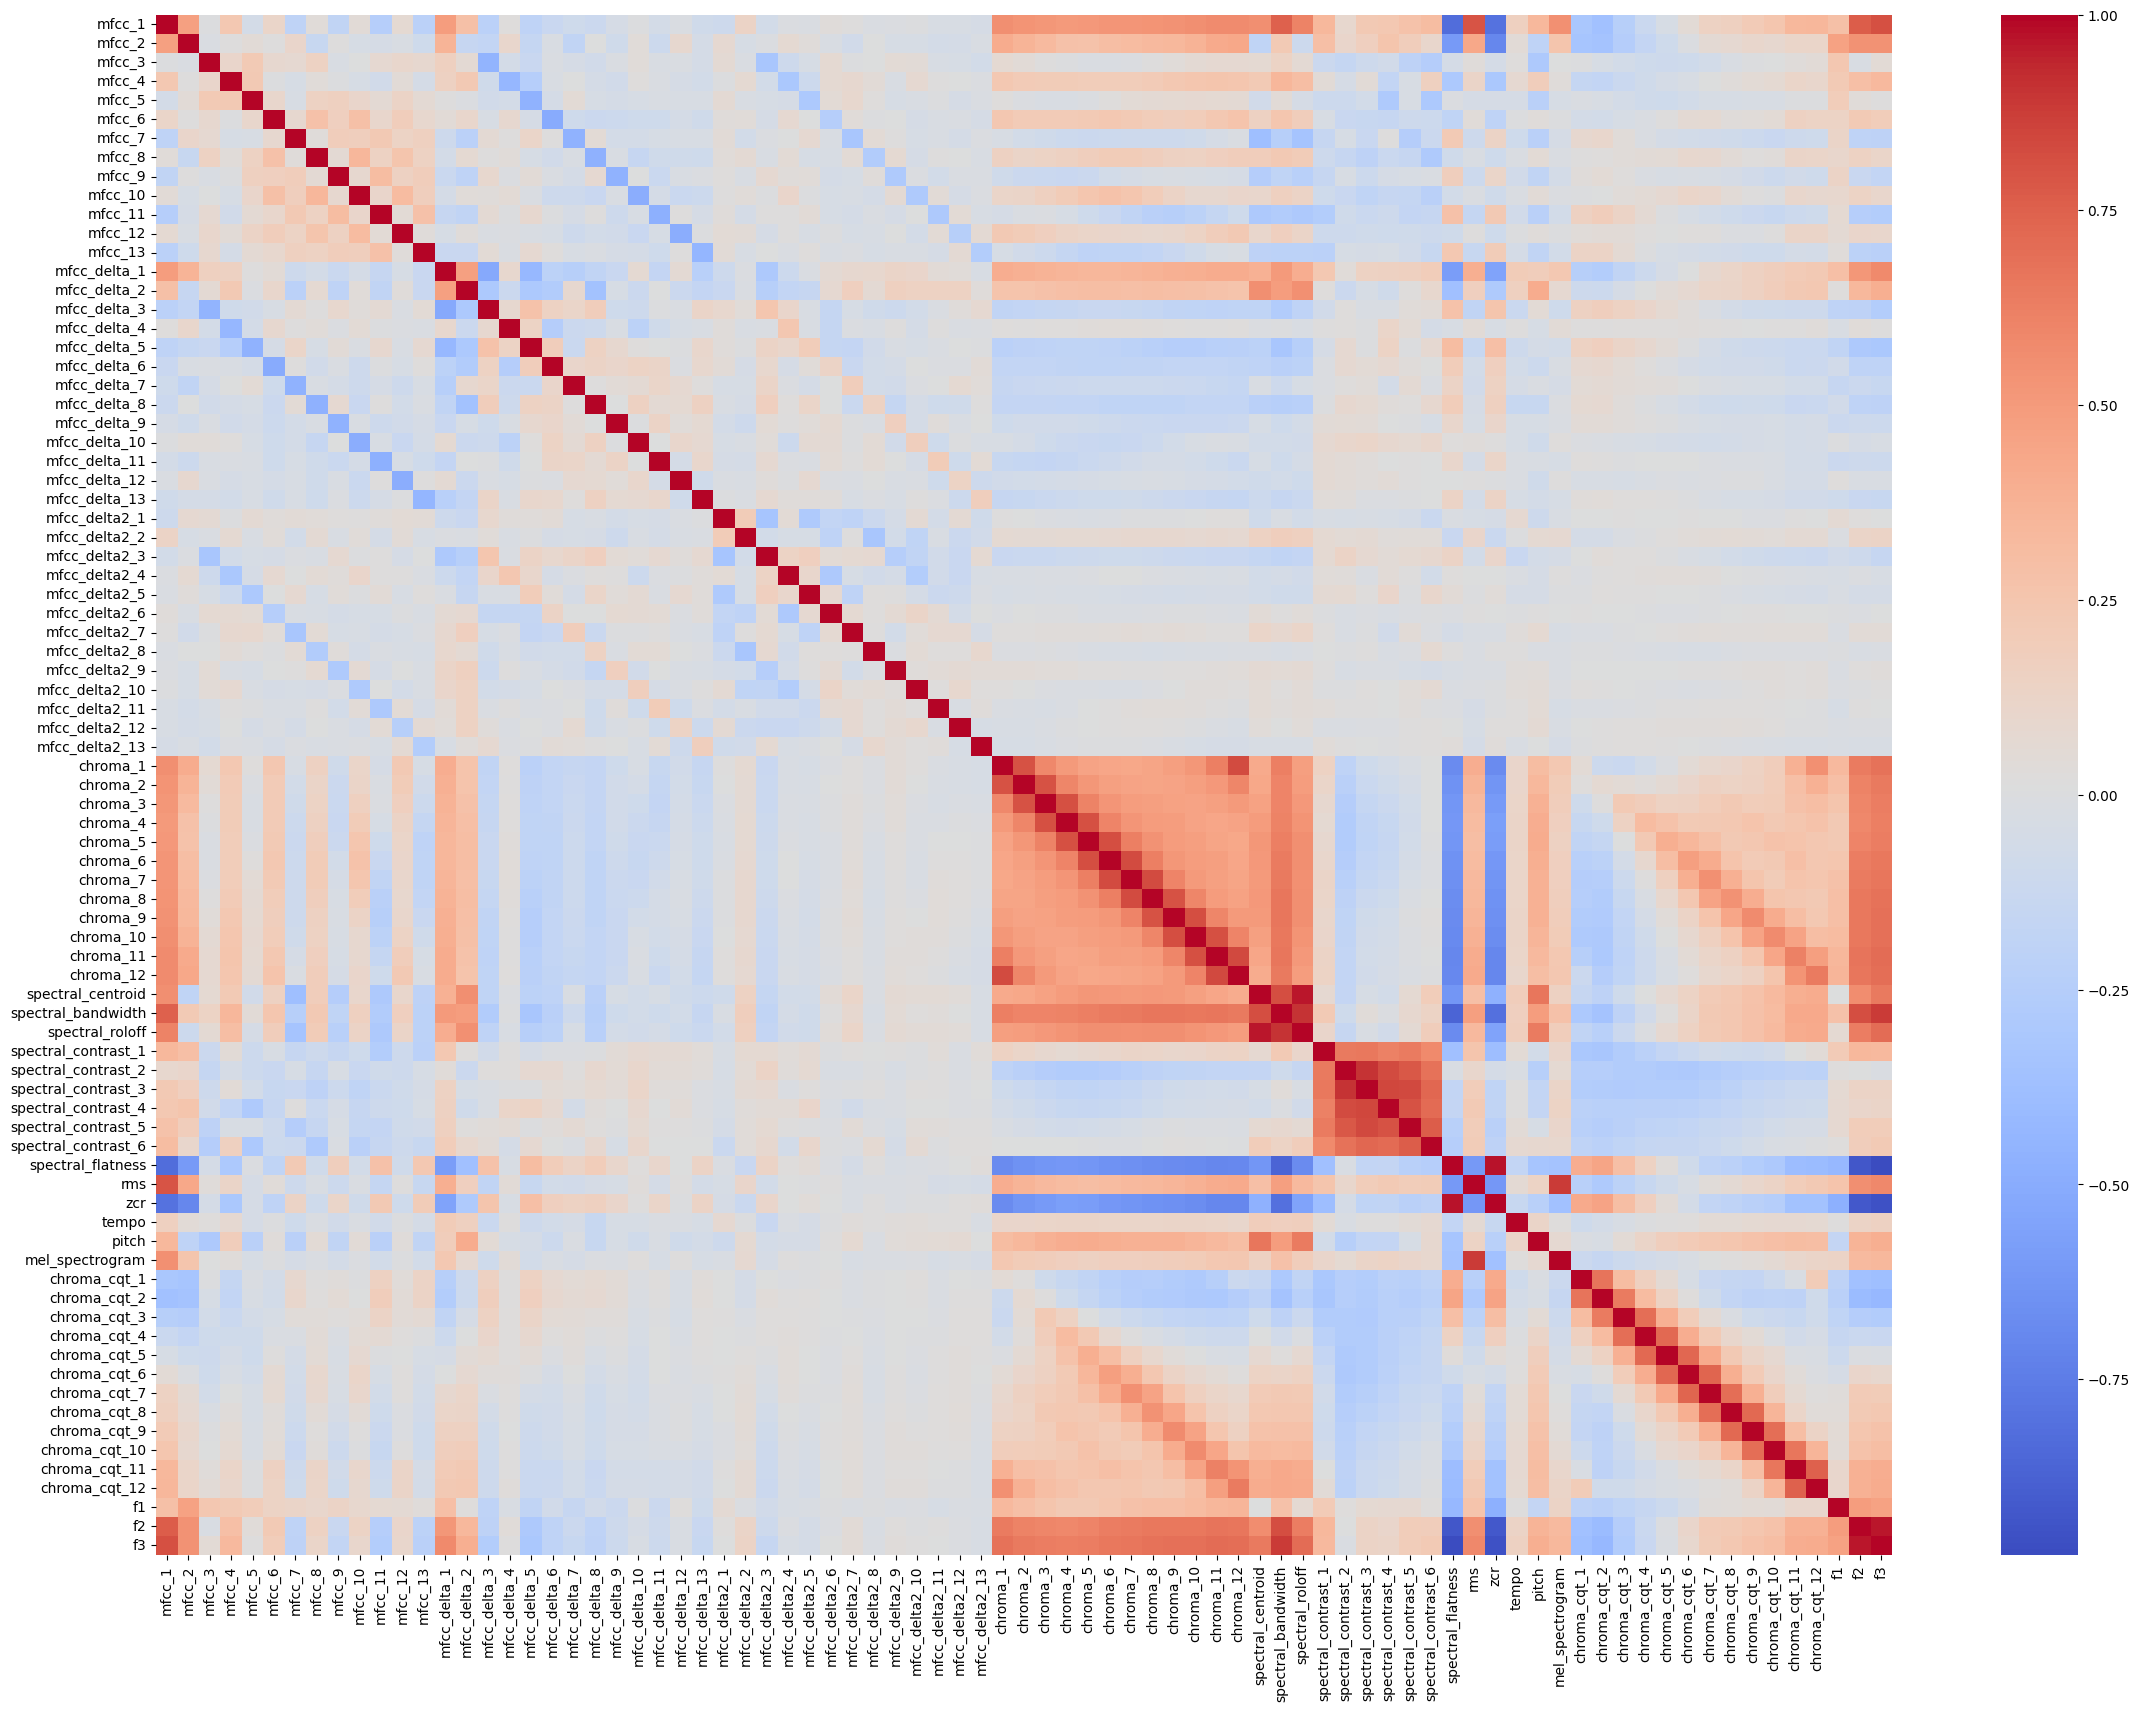

In [43]:
# correlation between features
correlation = features.corr()
plt.figure(figsize=(28, 20))
sns.heatmap(correlation, cmap = 'coolwarm')
plt.show()

The above correlatuon matrix shows that although our features are dependent on each other and thus naive bayes might not be our best option, however the features are not extremely dependent on each other and thus we can use a decision tree classifier and random forest classifier to classify the data.\
Random Forest Classifier will work the best as it will take the average of all the decision trees and thus will be able to classify the data better avoiding overfitting.

#### Train Test Split

In [44]:
def train_test_split(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    shuffle_indices = np.random.permutation(len(X))
    test_set_size = int(len(X) * test_size)
    test_indices = shuffle_indices[:test_set_size]
    train_indices = shuffle_indices[test_set_size:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [45]:
X_train.shape

(41414, 81)

In [46]:
y_train.shape

(41414,)

In [47]:
X_test.shape

(10353, 81)

In [48]:
y_test.shape

(10353,)

In [58]:
# Decision Tree Classifier

dt_model = DecisionTreeClassifier(max_depth=50)
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)

In [62]:
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

print("Train Accuracy: ", accuracy(y_train, dt_model.predict(X_train)))
print("Test Accuracy: ", accuracy(y_test, y_pred))

Train Accuracy:  0.9999758535760854
Test Accuracy:  0.31304935767410413
